In [1]:
from common.DAL import get_models_data_frame, get_model
df_models = get_models_data_frame()
df_models.head()

,accuracy,loss,history_location,id,val_accuracy,val_loss,image_base_net,model_location,class_strategy
0,0.9570,0.1248,,1,0.542,2.7968,resnet50,C:\Users\Public\Documents\Data\2018\vqa_models...,None
1,0.9776,0.0843,,2,0.648,2.7968,vgg19,C:\Users\Public\Documents\Data\2018\vqa_models...,None


In [2]:
model_id = 1
model_dal = get_model(model_id)
model_dal

Model(id=1,
	model_location=C:\Users\Public\Documents\Data\2018\vqa_models\20180730_0524_48\vqa_model_ClassifyStrategies.CATEGORIAL_trained.h5,
	history_location=,
	image_base_net=resnet50,
	loss=0.1248,
	val_loss=2.7968,
	accuracy=0.957,
	val_accuracy=0.542,
	class_strategy=None)

In [3]:
#From Step #2:
vqa_specs_location = 'C:\\Users\\avitu\\Documents\\GitHub\\VQA-MED\\VQA-MED\\VQA.Python\\data\\vqa_specs.pkl'

In [4]:
model_location = model_dal.model_location
model_location
# model_location = 'C:\\Users\\Public\\Documents\\Data\\2018\\vqa_models\\20180629_1220_23\\vqa_model_ClassifyStrategies.NLP_trained.h5'

'C:\\Users\\Public\\Documents\\Data\\2018\\vqa_models\\20180730_0524_48\\vqa_model_ClassifyStrategies.CATEGORIAL_trained.h5'

In [5]:
# %%capture
import os
import numpy as np
from pandas import HDFStore
from vqa_logger import logger 
from enum import Enum
import IPython
from keras.models import load_model

c:\local\Anaconda3-4.1.1-Windows-x86_64\envs\conda_env\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from common.constatns import images_path_test
from common.utils import VerboseTimer
from parsers.VQA18 import Vqa18Base
from common.functions import get_size, get_highlited_function_code, normalize_data_strucrture
from vqa_logger import logger
from common.os_utils import File 

In [7]:
with VerboseTimer("Loading Model"):
    model = load_model(model_location)

Loading Model: 0:00:23.817817


In [8]:
vqa_specs = File.load_pickle(vqa_specs_location)
data_location = vqa_specs.data_location
data_location

'C:\\Users\\avitu\\Documents\\GitHub\\VQA-MED\\VQA-MED\\VQA.Python\\data\\model_input.h5'

In [9]:
code = get_highlited_function_code(normalize_data_strucrture,remove_comments=True)
IPython.display.display(code)

In [10]:
logger.debug(f"Loading test data from {data_location}")
with VerboseTimer("Loading Test Data"):
    with HDFStore(data_location) as store:        
        df_data = store['test']

[19:26:13][DEBUG] Loading test data from C:\Users\avitu\Documents\GitHub\VQA-MED\VQA-MED\VQA.Python\data\model_input.h5
Loading Test Data: 0:00:00.888724


In [11]:
df_data.head(2)

,image_name,question,answer,group,path,tumor,hematoma,brain,abdomen,neck,liver,imaging_device,answer_embedding,question_embedding,image
0,AIAN-16-292-g001.jpg,where is tumor located?,NaN,test,C:\Users\Public\Documents\Data\2018\VQAMed2018...,True,False,False,False,False,False,mri,,"[[0.12621575593948364, 0.4218316078186035, -2....","[[[28, 28, 28], [26, 26, 26], [21, 21, 21], [2..."
1,1757-1626-0002-0000007275-001.jpg,what does abdomal CT show?,NaN,test,C:\Users\Public\Documents\Data\2018\VQAMed2018...,False,False,False,False,False,False,ct,,"[[-1.8509955406188965, 2.72301983833313, 0.357...","[[[4, 3, 5], [5, 4, 6], [11, 10, 14], [7, 6, 1..."


## TODO: Duplicate:

In [12]:
def concate_row(df, col):
    return np.concatenate(df[col], axis=0)

def get_features_and_labels(df):
    image_features = np.asarray([np.array(im) for im in df['image']])
    # np.concatenate(image_features['question_embedding'], axis=0).shape
    question_features = concate_row(df, 'question_embedding') 

    reshaped_q = np.array([a.reshape(a.shape + (1,)) for a in question_features])
    
    features = ([f for f in [reshaped_q, image_features]])    
    
    return features
    
    


In [13]:
features = get_features_and_labels(df_data)

In [14]:

p = model.predict(features)

In [15]:
p

array([[7.9741164e-07, 4.9113638e-08, 9.9999917e-01, 9.8733870e-24],
       [9.8996311e-01, 2.0971180e-07, 1.0036601e-02, 3.0911599e-22],
       [8.6206800e-01, 2.9084333e-03, 1.3502358e-01, 1.9758553e-14],
       ...,
       [9.6357453e-06, 8.5786122e-01, 1.4212921e-01, 1.3884297e-13],
       [9.9995863e-01, 5.3401038e-07, 4.0906380e-05, 9.3426908e-35],
       [9.9999285e-01, 4.6891023e-07, 6.6232687e-06, 4.0806767e-28]],
      dtype=float32)

In [16]:
predictions = [np.argmax(a, axis=None, out=None) for a in p]
predictions[:10]

[2, 0, 0, 2, 0, 2, 0, 0, 2, 0]

In [17]:
meta_data = vqa_specs.meta_data
ix_to_img_device = meta_data['ix_to_img_device']
results = [ix_to_img_device[i] for i in predictions]
results[:10]

list(zip(df_data.image_name.values, results))[:10]

[('AIAN-16-292-g001.jpg', 'unknown'),
 ('1757-1626-0002-0000007275-001.jpg', 'ct'),
 ('jkms-25-1536-g002.jpg', 'ct'),
 ('IJRI-23-243-g004.jpg', 'unknown'),
 ('kjh-47-142-g001.jpg', 'ct'),
 ('1477-7819-10-209-1.jpg', 'unknown'),
 ('CEJU-66-00217-g006.jpg', 'ct'),
 ('1758-2555-2-24-4.jpg', 'ct'),
 ('crn-0007-0134-g01.jpg', 'unknown'),
 ('JIAPS-20-68-g003.jpg', 'ct')]

In [22]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
idx = 42
image_names = df_data.image_name.values
image_name = image_names[idx]

print(f'Result: {results[idx]}')
idxs = [index for index, value in enumerate(image_names) if value == image_name]
all_results_for_image = {results[idx] for idx in idxs}
print(f'All results for image: {results[idx]}')
print('DataFrame:')
      
df_image = df_data[df_data.image_name==image_name]

image_path = df_image['path'].values[0]


df_mini = df_image[['question','answer']]
df_mini

Result: ct
All results for image: ct
DataFrame:


,question,answer
42,where is tumor located?,NaN
392,what does MRI show?,NaN


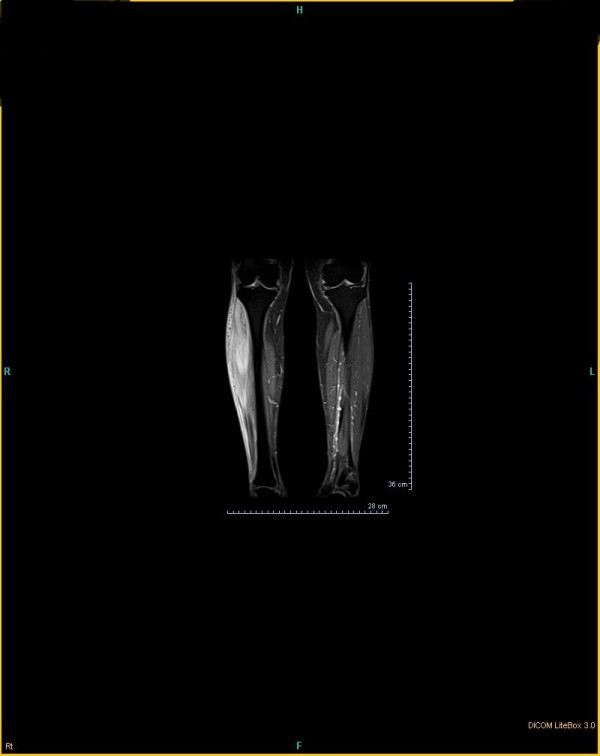

In [23]:
from IPython.display import Image
Image(filename = image_path, width=400, height=400)